# DataStory - Lyrics Analyzer

Ina Widmer, Michael Job  
Jan. 2019  
dsp FHNW

## Abstract

Analyse the words used in swiss chartsongs (1998 - 2018). Which words are used the most, in what year.  
Are words like 'facebook' and so on since the rise of social media present in chartsongs?  
Some of the social media words appear in the analysed lyrics, but only a few times. Words like love, know, yeah, baby stay most common.

## Introduction

### Questions

* Do words from social media appear in chart songs? 
* Do these appearings correlate with the rise of social media?
* What other words are most common?

### Data Source

Chartsongs of the last 20 years are gathered from swiss charts website https://hitparade.ch/charts/singles . 

Data Limitation:  
* Time range: from 4.10.1998 to 7.10.2018  
* Time slot: every three months (every 84 days)  
* Songs: Top 25 songs per date

The lyrics were collected over the API https://lyrics.ovh/.   

### Data Fetching

There is no API provided for the swiss charts data, so we used webcrawling. The crawler called for each required chartsdate the hitparade.ch website for the specific date  
Example: https://hitparade.ch/charts/singles/16-09-2018  


Run Pyhton Script ```DataFetching.py``` to fetch data and save to JSON file.

Record sample JSON file
```
[{   
    "artist": "Calvin Harris & Sam Smith",  // Song interpret
    "title": "Promises",                    // Song title
    "date": "07-10-2018",                   // Charts Date
    "ranking": "3",                         // Charts Ranking
    "lyrics": "Are you drunk enough? ..."   // Lyrics
 }, 
    ...
 ]
```  

### Analyzed Social Media Words:
Source: Self defined

In [1]:
import pandas as pd
social_data = pd.read_json(path_or_buf='data/socialMediaWords.json')
print(social_data)

          some
0     facebook
1      twitter
2         xing
3     linkedin
4      youtube
5    instagram
6     snapchat
7     whatsapp
8        tweet
9     unfriend
10  influencer
11     google+
12     mention
13        post
14     retweet
15      repost
16       share
17     hashtag
18      social
19       media
20        chat
21    emoticon
22      emotji
23   pinterest
24      tumblr
25       weibo
26      flickr


## Results

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

# read json data from file into pandas object
path2data = 'data/charts_lyrics_1998-2018.json'
data = pd.read_json(path_or_buf=path2data, orient=None, typ='frame', dtype=True, convert_axes=True, convert_dates=True,
                    keep_default_dates=True, numpy=False, precise_float=False, date_unit=None, encoding='utf-8',
                    lines=False, chunksize=None, compression='infer')

#### Description fetched Data

In [3]:
print("Fetched songs: \t\t\t"+str(data.artist.count()))
print("Songs with lyrics: \t\t"+str((data.lyrics.values != '').sum()))
print("Songs with no lyrics: \t\t"+str((data.lyrics.values == '').sum()))
print("Number of unique songlyrics: \t"+str(data.lyrics.nunique()))

Fetched songs: 			2200
Songs with lyrics: 		1966
Songs with no lyrics: 		234
Number of unique songlyrics: 	1665


#### Description words occurrence in lyrics

describe lyrics words occurrence:
         occurrence
count  22138.000000
mean      15.842036
std      113.251787
min        1.000000
25%        1.000000
50%        2.000000
75%        6.000000
max     5366.000000
top20_words:
        occurrence
count    20.000000
mean   2986.650000
std    1162.059663
min    1699.000000
25%    1963.750000
50%    2753.500000
75%    3841.250000
max    5366.000000


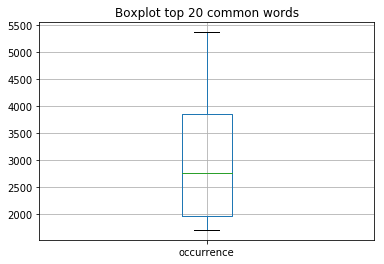

In [4]:
def get_top_n_words(lyrics, n=None):
    """ Function to get n most common words for data """
    
    vec = CountVectorizer(stop_words='english').fit(lyrics)
    bag_of_words = vec.transform(lyrics)    # matrix where each row represents a specific text
    sum_words = bag_of_words.sum(axis=0)    # vector that contains the sum of each word occurrence
    words_freq = pd.DataFrame([(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()], columns=['word', 'occurrence'])
    words_freq = words_freq.sort_values(by=['occurrence'], ascending=False)
    return words_freq.head(n)


df_all = get_top_n_words(data.lyrics)  # Get all words
print("describe lyrics words occurrence:")
print(df_all.describe())

top20_words = get_top_n_words(data.lyrics, 20)  # Get top 20 words
print("top20_words:")
print(top20_words.describe())

top20_words.boxplot()
plt.title("Boxplot top 20 common words")
plt.show()

#### Most common words for all Data (1998 - 2018)

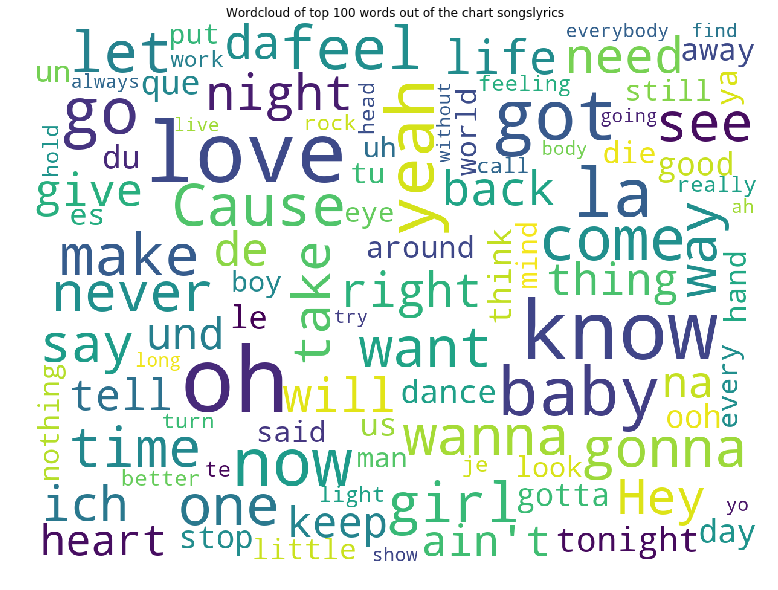

In [9]:
def create_word_cloud(textinput):
    """ Create wordcloud for string of words."""
    
    # Source https://github.com/amueller/word_cloud 
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

    # Create stopword list:
    stopwords = set(STOPWORDS)
    # stopwords.update(["der", "die", "das"])
    
    print("There are {} words in the combination of all lyrics.".format(len(textinput)))

    # lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(stopwords=stopwords, width=1200, height=900, max_font_size=150, max_words=100, background_color="white", collocations=False).generate(textinput)
    
    # wordcloud.to_file("data/allwords-cloud.png")


text = " ".join(lyrics for lyrics in data.lyrics)

# generate Wordcloud with most common words, package WordCloud needs to be installed (skipped here as it is not on mlhub, show saved image)
# create_word_cloud(text)


plt.figure(figsize=(14, 10))
img = plt.imread("data/allwords-cloud.png")
plt.imshow(img)
plt.axis('off')
plt.title("Wordcloud of top 100 words out of the chart songlyrics")
plt.show()

#### Social media words in all Data (1998 - 2018)

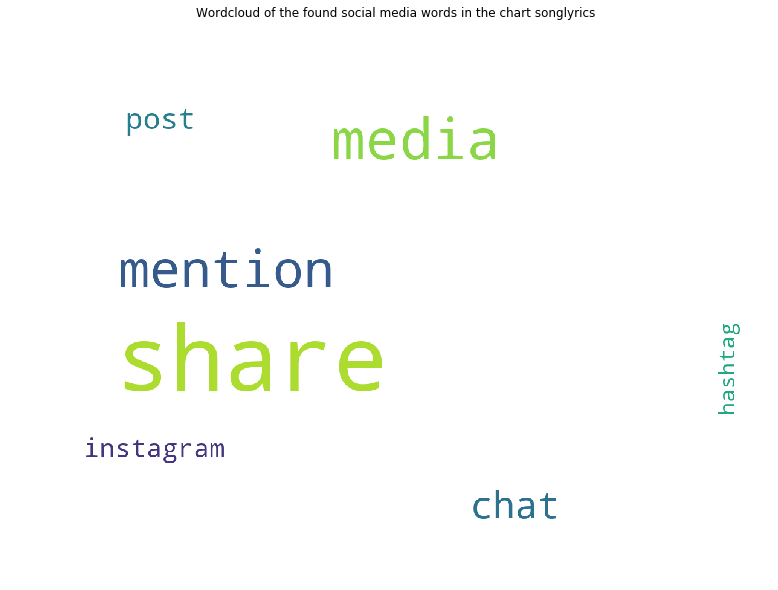

In [10]:
social_data_counts = []

# get all words with occurence count
word_frequenz = get_top_n_words(data.lyrics)

# get all social media words from lyrics with occurence count
social_data_counts = word_frequenz[word_frequenz.word.isin(social_data.some)]

# get one string containing all social media words times their occurrence for creating a wordcloud
social_data_text = []


def create_word_string(w):
    """ Create a string for wordcloud. Add word as many time as it occurs """
    
    social_data_text.append((w.word+" ")*w.occurrence)


social_data_counts.apply(create_word_string, axis=1)

#create_word_cloud(social_data_text)  # as package is not installed here, skip creation and show preprocessed image

plt.figure(figsize=(14, 10))
img = plt.imread("data/social-cloud.png")
plt.imshow(img)
plt.axis('off')
plt.title("Wordcloud of the found social media words in the chart songlyrics")
plt.show()

In [7]:
def get_word_count_per_year(word):
    """ Partition data into years """
    years = [g for n, g in data.set_index('date').groupby(pd.Grouper(freq='Y'))]

    word_freq = pd.DataFrame(columns=['year', 'occurrence'])
    
    # Get most common words for each year
    for i in range(len(years) - 1):
        common_words = get_top_n_words(years[i].lyrics)
        # Find count for word
        record = common_words[common_words['word'] == word]
        
        # if word doesn't exist set occurrence to 0
        if record.empty: 
            occurrence = 0 
        else:
            occurrence = record.occurrence.values[0]
        word_freq = word_freq.append({'year': years[i].index[0].year, 'occurrence': occurrence}, ignore_index=True)
    return word_freq

def save_count(row):
    """ Save year and occurrence for each social media word """
    counts = get_word_count_per_year(row.some)
    if sum(counts.occurrence) > 0:
        social_data_counts_per_year.append([row.some, counts])  # Add only social words that occure in lyrics
        
social_data_counts_per_year = []        
social_data.apply(save_count, axis=1) 
social_data_counts_per_year = pd.DataFrame(social_data_counts_per_year)
print("done")

done


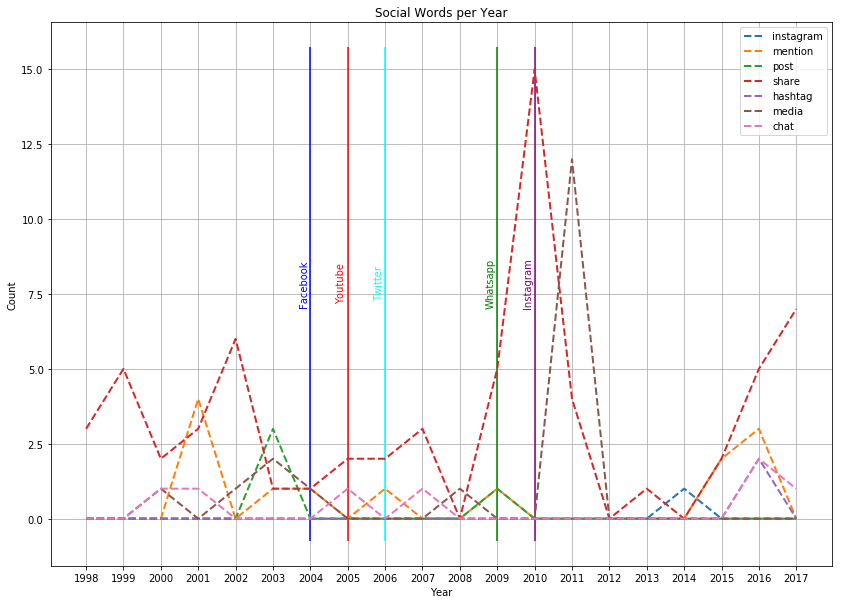

In [13]:
def plot_row(row):
    """ plot line for each word """
    _ = ax.plot(row[1]['year'], row[1]['occurrence'], linestyle="--", label=row[0], linewidth="2")
    _ = ax.set_xticks(np.arange(min(row[1]['year']), max(row[1]['year'])+1, 1.0))
    
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 10))
fig.patch.set_facecolor('white')

social_data_counts_per_year.apply(plot_row, axis=1)

_ = ax.set_title('Social Words per Year')
_ = ax.set_xlabel('Year')
_ = ax.set_ylabel('Count')
_ = ax.grid()
ax.legend()

ymin, ymax = ax.get_ylim()
_ = ax.vlines(2004, ymin, ymax, color="blue")
_ = ax.text(2004-.3, ymax/2, "Facebook", rotation=90, verticalalignment="center", color="blue")
_ = ax.vlines(2010, ymin, ymax, color="purple")
_ = ax.text(2010-.3, ymax/2, "Instagram", rotation=90, verticalalignment="center", color="purple")
_ = ax.vlines(2006, ymin, ymax, color="cyan")
_ = ax.text(2006-.3, ymax/2, "Twitter", rotation=90, verticalalignment="center", color="cyan")
_ = ax.vlines(2005, ymin, ymax, color="red")
_ = ax.text(2005-.3, ymax/2, "Youtube", rotation=90, verticalalignment="center", color="red")
_ = ax.vlines(2009, ymin, ymax, color="green")
_ = ax.text(2009-.3, ymax/2, "Whatsapp", rotation=90, verticalalignment="center", color="green")

plt.show()

## Conclusion

Buzz words of common social media do not really appear in chart lyrics. Only very few words were found in the lyrics. And these in a very small number, compared to other common words. Also a word like "share" can be used to share a meal or something between two people or to post some content online. So it must be assumed that the rare findings may not even be in a social media context at all. As we expected the songwriters still concern about love and other traditional subjects in their songs. And we think this is quite allright.